<a href="https://colab.research.google.com/github/Sinamhd9/Frame_interpolation/blob/main/frame_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import cv2
import sys
import numpy as np
import pickle
import numpy as np
import os

BLUR_OCC = 3

def readFlowFile(file):
    '''
    credit: this function code is obtained from: https://github.com/Johswald/flow-code-python
    '''
    TAG_FLOAT = 202021.25
    assert type(file) is str, "file is not str %r" % str(file)
    assert os.path.isfile(file) is True, "file does not exist %r" % str(file)
    assert file[-4:] == '.flo', "file ending is not .flo %r" % file[-4:]
    f = open(file, 'rb')
    flo_number = np.fromfile(f, np.float32, count=1)[0]
    assert flo_number == TAG_FLOAT, 'Flow number %r incorrect. Invalid .flo file' % flo_number
    w = np.fromfile(f, np.int32, count=1)[0]
    h = np.fromfile(f, np.int32, count=1)[0]
    data = np.fromfile(f, np.float32, count=2 * w * h)
    # Reshape data into 3D array (columns, rows, bands)
    flow = np.resize(data, (int(h), int(w), 2))
    f.close()
    return flow

In [26]:
def occlusions(flow0, frame0, frame1):
    '''
    Follow the step 3 in 3.3.2 of
    Simon Baker, Daniel Scharstein, J. P. Lewis, Stefan Roth, Michael J. Black, and Richard Szeliski. A Database and Evaluation Methodology
    for Optical Flow, International Journal of Computer Vision, 92(1):1-31, March 2011.
    :param flow0: dense optical flow
    :param frame0: input image frame 0
    :param frame1: input image frame 1
    :return:
    '''
    height, width, _ = flow0.shape
    occ0 = np.zeros([height, width], dtype=np.float32)
    occ1 = np.zeros([height, width], dtype=np.float32)

    # ==================================================
    # ===== step 4/ warp flow field to target frame
    # ==================================================
    flow1 = interpflow(flow0, frame0, frame1, 1.0)

    # ==================================================
    # ===== main part of step 5
    # ==================================================
    for y in range(0, height):
        for x in range(0, width):
            if np.int32(y + flow0[y, x, 1] + 0.5) < height and np.int32(x + flow0[y, x, 0] + 0.5) < width:
                if np.sum(np.abs(flow0[y, x] - flow1[
                    np.int32(y + flow0[y, x, 1] + 0.5), np.int32(x + flow0[y, x, 0] + 0.5)])) > 0.5:
                    occ0[y, x] = 1
            else:
                occ0[y, x] = 1
    for y in range(0, height):
        for x in range(0, width):
            if np.any(abs(flow1[y, x]) > 10 ** 9) == True or np.any(np.isnan(flow1[y, x])) == True:
                occ1[y, x] = 1
    return occ0, occ1

In [27]:
def bilinear(im, y, x):
    x = np.clip(x, 0, im.shape[1] - 1)
    y = np.clip(y, 0, im.shape[0] - 1)
    x = np.asarray(x)
    y = np.asarray(y)
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    x0 = np.clip(x0, 0, im.shape[1] - 1)
    x1 = np.clip(x1, 0, im.shape[1] - 1)
    y0 = np.clip(y0, 0, im.shape[0] - 1)
    y1 = np.clip(y1, 0, im.shape[0] - 1)
    Ia = im[y0, x0]
    Ib = im[y1, x0]
    Ic = im[y0, x1]
    Id = im[y1, x1]
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)
    return wa * Ia + wb * Ib + wc * Ic + wd * Id

In [28]:

def find_holes(flow):
    '''
    Find a mask of holes in a given flow matrix
    Determine it is a hole if a vector length is too long: >10^9, of it contains NAN, of INF
    :param flow: an dense optical flow matrix of shape [h,w,2], containing a vector [ux,uy] for each pixel
    :return: a mask annotated 0=hole, 1=no hole
    '''
    h, w, _ = flow.shape
    holes = np.zeros((h, w))
    for y in range(h):
        for x in range(w):
            if np.any(abs(flow[y, x]) > 10 ** 9) or np.any(np.isnan(flow[y, x])):
                holes[y, x] = 0
            else:
                holes[y, x] = 1
    return holes

In [29]:

def holefill(flow, holes):
    '''
    fill holes in order: row then column, until fill in all the holes in the flow
    :param flow: matrix of dense optical flow, it has shape [h,w,2]
    :param holes: a binary mask that annotate the location of a hole, 0=hole, 1=no hole
    :return: flow: updated flow
    '''
    h, w, _ = flow.shape
    has_hole = 1
    while has_hole == 1:
        for y in range(0, h):
            for x in range(0, w):
                if holes[y, x] == 0:
                    yr = np.clip(np.arange(y - 1, y + 2), 0, h - 1)
                    xr = np.clip(np.arange(x - 1, x + 2), 0, w - 1)
                    a0 = flow[yr[0]:yr[-1] + 1, xr[0]:xr[-1] + 1, 0]
                    a1 = flow[yr[0]:yr[-1] + 1, xr[0]:xr[-1] + 1, 1]
                    if np.any(a0[holes[yr[0]:yr[-1] + 1, xr[0]:xr[-1] + 1] == 1]):
                        flow[y, x, 0] = np.mean(a0[holes[yr[0]:yr[-1] + 1, xr[0]:xr[-1] + 1] == 1])
                        flow[y, x, 1] = np.mean(a1[holes[yr[0]:yr[-1] + 1, xr[0]:xr[-1] + 1] == 1])
                        holes[y, x] = 1
                    else:
                        flow[y, x, 0] = 10 ** 10
                        flow[y, x, 1] = 10 ** 10
                        holes[y, x] = 0
        if np.all(holes == 1):
            has_hole = 0
    return flow

In [30]:
def interpflow(flow, frame0, frame1, t):
    '''
    Forward warping flow (from frame0 to frame1) to a position t in the middle of the 2 frames
    Follow the algorithm (1) described in 3.3.2 of
    Simon Baker, Daniel Scharstein, J. P. Lewis, Stefan Roth, Michael J. Black, and Richard Szeliski. A Database and Evaluation Methodology
    for Optical Flow, International Journal of Computer Vision, 92(1):1-31, March 2011.

    :param flow: dense optical flow from frame0 to frame1
    :param frame0: input image frame 0
    :param frame1: input image frame 1
    :param t: the intermiddite position in the middle of the 2 input frames
    :return: a warped flow
    '''
    h, w, _ = frame0.shape
    iflow = np.ones_like(flow).astype(np.float32) * 10**10
    a = np.ones((h, w)).astype(np.float32) * 100000
    for yy in np.arange(-0.5, 0.51, 0.5):
        for xx in np.arange(-0.5, 0.51, 0.5):
            for y in range(0, h):
                for x in range(0, w):
                    nx = np.int32(x + t * flow[y, x, 0] + xx + 0.5)
                    ny = np.int32(y + t * flow[y, x, 1] + yy + 0.5)
                    x1 = x + 1 * flow[y, x, 0] + xx
                    y1 = y + 1 * flow[y, x, 1] + yy
                    pixel1 = bilinear(frame1, y1, x1)
                    b = np.sum(np.abs(frame0[y, x] - pixel1))
                    if 0 <= ny < h and 0 <= nx < w and b <= a[ny, nx]:
                        iflow[ny, nx] = flow[y, x]
                        a[ny, nx] = b
    return iflow

In [31]:
def warpimages(iflow, frame0, frame1, occ0, occ1, t):
    '''
    Compute the colors of the interpolated pixels by inverse-warping frame 0 and frame 1 to the postion t based on the
    forwarded-warped flow iflow at t
    Follow the algorithm (4) described in 3.3.2 of
    Simon Baker, Daniel Scharstein, J. P. Lewis, Stefan Roth, Michael J. Black, and Richard Szeliski. A Database and Evaluation Methodology
     for Optical Flow, International Journal of Computer Vision, 92(1):1-31, March 2011.

    :param iflow: forwarded-warped (from flow0) at position t
    :param frame0: input image frame 0
    :param frame1: input image frame 1
    :param occ0: occlusion mask of frame 0
    :param occ1: occlusion mask of frame 1
    :param t: interpolated position t
    :return: interpolated image at position t in the middle of the 2 input frames
    '''

    iframe = np.zeros_like(frame0).astype(np.float32)

    iframe = np.zeros_like(frame0).astype(np.float32)
    h, w, _ = iframe.shape
    for y in range(h):
        for x in range(w):
            if occ0[y, x]== 1 and occ1[y, x]!=1:
                iframe[y,x] = bilinear(frame0, y-t*iflow[y,x,1], x-t*iflow[y,x,0])
            elif occ1[y, x]==1 and occ0[y, x]!=1:
                iframe[y,x] = bilinear(frame1, y+(1-t)*iflow[y,x,1], x+(1-t)*iflow[y,x,0])
            elif occ1[y, x]!=1 and occ0[y, x]!=1:
                iframe[y,x] =(1-t)*bilinear(frame0, y-t*iflow[y,x,1], x-t*iflow[y,x,0]) + t*bilinear(frame1, y+(1-t)*iflow[y,x,1], x+(1-t)*iflow[y,x,0])
    return iframe

    return iframe

In [32]:
def blur(im):
    '''
    blur using a gaussian kernel [5,5] using opencv function: cv2.GaussianBlur, sigma=0
    :param im:
    :return updated im:
    '''
    im = cv2.GaussianBlur(im,(5, 5),0)
    return im

In [33]:
def internp(frame0, frame1, t=0.5, flow0=None):
    '''
    :param frame0: beggining frame
    :param frame1: ending frame
    :return frame_t: an interpolated frame at time t
    '''
    print('==============================')
    print('===== interpolate an intermediate frame at t=', str(t))
    print('==============================')

    # ==================================================
    # ===== 1/ find the optical flow between the two given images: from frame0 to frame1,
    #  if there is no given flow0, run opencv function to extract it
    # ==================================================
    if flow0 is None:
        i1 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
        i2 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        flow0 = cv2.calcOpticalFlowFarneback(i1, i2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # ==================================================
    # ===== 2/ find holes in the flow
    # ==================================================
    holes0 = find_holes(flow0)
    # ==================================================
    # ===== 3/ fill in any hole using an outside-in strategy
    # ==================================================
    flow0 = holefill(flow0, holes0)

    # ==================================================
    # ===== 5/ estimate occlusion mask
    # ==================================================
    occ0, occ1 = occlusions(flow0, frame0, frame1)

    # ==================================================
    # ===== step 6/ blur occlusion mask
    # ==================================================
    for iblur in range(0, BLUR_OCC):
        occ0 = blur(occ0)
        occ1 = blur(occ1)
    # ==================================================
    # ===== step 7/ forward-warp the flow to time t to get flow_t
    # ==================================================
    flow_t = interpflow(flow0, frame0, frame1, t)

    # ==================================================
    # ===== step 8/ find holes in the estimated flow_t
    # ==================================================
    holes1 = find_holes(flow_t)

    # ===== fill in any hole in flow_t using an outside-in strategy
    flow_t = holefill(flow_t, holes1)

    # ==================================================
    # ===== 9/ inverse-warp frame 0 and frame 1 to the target time t
    # ==================================================
    frame_t = warpimages(flow_t, frame0, frame1, occ0, occ1, t)

    return frame_t

===== interpolate an intermediate frame at t= 0.5


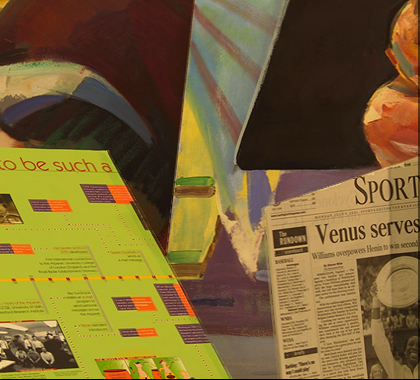

In [34]:
from google.colab.patches import cv2_imshow
    # ===================================
    # example:
    # python interp_skeleton.py frame0.png frame1.png flow0.flo frame05.png
    # ===================================

frame0 = cv2.imread('frame0.png')
frame1 = cv2.imread('frame1.png')
flow0 = readFlowFile('flow0.flo')
frame_t = internp(frame0=frame0, frame1=frame1, t=0.5, flow0=flow0)
cv2.imwrite(filename='final_sina.png', img=(frame_t * 1.0).clip(0.0, 255.0).astype(np.uint8))
cv2_imshow((frame_t * 1.0).clip(0.0, 255.0).astype(np.uint8))